In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Analyse et Classification d'Images CIFAR-100 avec PCA et MLP et Mlflow
Ce notebook implémente un modèle de classification basé sur un réseau de neurones multi-couches (MLP) pour le jeu de données CIFAR-100.


In [1]:
!pip install mlflow dagshub --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.10.1 requires cubinlinker, which is not installed.
cudf 24.10.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.10.1 requires libcudf==24.10.*, which is not installed.
cudf 24.10.1 requires ptxcompiler, which is not installed.
cuml 24.10.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 24.10.0 requires cuvs==24.10.*, which is not installed.
cuml 24.10.0 requires nvidia-cublas, which is not installed.
cuml 24.10.0 requires nvidia-cufft, which is not installed.
cuml 24.10.0 requires nvidia-curand, which is not installed.
cuml 24.10.0 requires nvidia-cusolver, which is not installed.
cuml 24.10.0 requires nvidia-cusparse, which is not installed.
dask-cudf 24.10.1 requires cupy-cuda11x>=12.0.0, which is not installed.
aiobotocore 2.15.2 requires botocore<1.35.37,>=1.35.16, but you h

## Intégration de DagsHub et MLflow

## Initialisation de DagsHub avec Python

DagsHub offre une intégration fluide pour le suivi des expériences et la gestion des projets ML. Cette documentation vous guide pour initialiser votre dépôt DagsHub et activer MLflow.

### Prérequis

- Un compte DagsHub ([Inscription](https://dagshub.com/))
- Un dépôt existant sur DagsHub
- La bibliothèque `dagshub` installée :
  ```bash
  pip install dagshub

### Description

Cette commande permet d'initialiser un projet DagsHub, en connectant un dépôt existant et en activant l'intégration avec MLflow pour le suivi des expériences.

### Exemple de Code
```python
import dagshub

# Initialiser le dépôt DagsHub avec intégration MLflow
dagshub.init(
    repo_owner='youcefkrookss',  # Nom du propriétaire du dépôt
    repo_name='test',           # Nom du dépôt
    mlflow=True                 # Active MLflow pour le suivi des expériences
)


In [2]:
import dagshub
dagshub.init(repo_owner='youcefkrookss', repo_name='test', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=cfb33389-c880-4536-abf6-1bf40ecaed86&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=83ac09bbf5914a6678c7b0ef150d6fb8afc174f94a2d7abf657f517c321a04ab




Output()

Accessing as ryadhseddik99

Initialized MLflow to track repo "youcefkrookss/test"

Repository youcefkrookss/test initialized!

In [6]:
!pip install mlflow

In [8]:
import mlflow

mlflow.set_tracking_uri('https://dagshub.com/youcefkrookss/test.mlflow')
mlflow.set_experiment(experiment_name="MLP_Cifar-100")

2024/12/11 00:05:20 INFO mlflow.tracking.fluent: Experiment with name 'MLP_Cifar-100' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/f1d404971314443a800a2caf051fbdc0', creation_time=1733875520656, experiment_id='1', last_update_time=1733875520656, lifecycle_stage='active', name='MLP_Cifar-100', tags={}>

## Importation des bibliothèques
Les bibliothèques utilisées incluent `tensorflow`, `sklearn`, `mlflow` pour les tâches suivantes :
1. Construction et entraînement du modèle.
2. Préparation des données avec PCA et augmentation.
3. Suivi des expériences.


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve, auc
from tensorflow.keras.datasets import cifar100
import keras_tuner as kt
import matplotlib.pyplot as plt
from itertools import cycle
import mlflow
import mlflow.keras

## Chargement et normalisation des données

In [ ]:
mlflow.tensorflow.autolog()

# Charger et normaliser les données
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

## Préparation des données
Les étapes de préparation incluent :
1. Augmentation des donnée
2. Converstion des images 32*32*3 en vecteur de 3072s3
2. Réduction dimensionnelle avec PC4.
3. Encodage one-hot des labels.


In [ ]:
# Augmentation des données
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(x_train)

# Réduction dimensionnelle avec PCA
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)
pca = PCA(n_components=500)  # Réduction à 500 dimensions
x_train_pca = pca.fit_transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)

# Encodage one-hot des étiquettes
y_train_one_hot = to_categorical(y_train, 100)
y_test_one_hot = to_categorical(y_test, 100)

## Construction du modèle MLP
Le modèle MLP comporte plusieurs couches entièrement connectées avec des options d'hyperparamètres.


In [ ]:
# Fonction pour construire le modèle MLP
def build_model(hp):
    model = Sequential([
        Dense(units=hp.Choice('units_layer_1', values=[256, 512]), activation='relu', input_shape=(500,)),
        Dense(units=hp.Choice('units_layer_2', values=[256, 512]), activation='relu'),
        Dense(units=hp.Choice('units_layer_3', values=[128, 256]), activation='relu'),
        Dense(units=hp.Choice('units_layer_4', values=[128, 256]), activation='relu'),
        Dense(100, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.0005])),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model


## Validation croisée et Évaluation Finale
Pour chaque fold, nous séparons les données en sous-ensembles d'entraînement et de validation, puis effectuons une recherche des hyperparamètres. Les résultats sont stockés pour chaque fold.
Après sélection du meilleur modèle, nous l'évaluons sur le jeu de test.

Trial 20 Complete [00h 03m 12s]
val_accuracy: 0.2241555154323578

Best val_accuracy So Far: 0.23501530289649963
Total elapsed time: 01h 07m 15s


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


2024/12/11 01:18:37 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpruojpkm7/model, flavor: tensorflow). Fall back to return ['tensorflow==2.16.1', 'cloudpickle==3.1.0']. Set logging level to DEBUG to see the full traceback. 
2024/12/11 01:18:43 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under mlflow-artifacts:/f1d404971314443a800a2caf051fbdc0/af7fb22194df4333b40e1486075a73a6/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.


521/521 - 1s - 1ms/step - accuracy: 0.1979 - loss: 13.2903


2024/12/11 01:18:47 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/12/11 01:18:52 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpuhm4w40m/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/12/11 01:18:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/11 01:18:56 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under mlflow-artifacts:/f1d404971314443a800a2caf051fbdc0/af7fb22194df4333b40e1486075a73a6/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.


🏃 View run Fold_1 at: https://dagshub.com/youcefkrookss/test.mlflow/#/experiments/1/runs/af7fb22194df4333b40e1486075a73a6
🧪 View experiment at: https://dagshub.com/youcefkrookss/test.mlflow/#/experiments/1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


2024/12/11 01:22:04 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp3kugu1d1/model, flavor: tensorflow). Fall back to return ['tensorflow==2.16.1', 'cloudpickle==3.1.0']. Set logging level to DEBUG to see the full traceback. 


521/521 - 1s - 1ms/step - accuracy: 0.1952 - loss: 13.5202


2024/12/11 01:22:13 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/12/11 01:22:18 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpjtil2z8h/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/12/11 01:22:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Fold_2 at: https://dagshub.com/youcefkrookss/test.mlflow/#/experiments/1/runs/dbca4a9c13ab455aa305706ecb46d229
🧪 View experiment at: https://dagshub.com/youcefkrookss/test.mlflow/#/experiments/1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


2024/12/11 01:25:25 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp8zh0u7dg/model, flavor: tensorflow). Fall back to return ['tensorflow==2.16.1', 'cloudpickle==3.1.0']. Set logging level to DEBUG to see the full traceback. 


521/521 - 1s - 1ms/step - accuracy: 0.1950 - loss: 13.5036


2024/12/11 01:25:34 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/12/11 01:25:39 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpe6kgjimo/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/12/11 01:25:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Fold_3 at: https://dagshub.com/youcefkrookss/test.mlflow/#/experiments/1/runs/136aaafc137b4c7bab35bf773e6c336e
🧪 View experiment at: https://dagshub.com/youcefkrookss/test.mlflow/#/experiments/1

=== Résultats des Folds ===
    Fold  Validation Loss  Validation Accuracy
0     1        13.290258             0.197876
1     2        13.520233             0.195236
2     3        13.503598             0.195008


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.0855 - loss: 4.0678 - val_accuracy: 0.1682 - val_loss: 3.5334
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2137 - loss: 3.2789 - val_accuracy: 0.1999 - val_loss: 3.3367
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2758 - loss: 2.9148 - val_accuracy: 0.2189 - val_loss: 3.2407
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3394 - loss: 2.5949 - val_accuracy: 0.2305 - val_loss: 3.2519
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4036 - loss: 2.2812 - val_accuracy: 0.2332 - val_loss: 3.3287
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4742 - loss: 1.9584 - val_accuracy: 0.2242 - val_loss: 3.5460
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5478 - loss: 1.6622 - val_accuracy: 0.2290 - val_loss: 3.6238
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6157 - loss: 1.3964 - 

2024/12/11 01:27:16 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpdhlyqfet/model, flavor: tensorflow). Fall back to return ['tensorflow==2.16.1', 'cloudpickle==3.1.0']. Set logging level to DEBUG to see the full traceback. 


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2082 - loss: 8.4888
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2024/12/11 01:27:26 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/12/11 01:27:31 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpkgq55t7_/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/12/11 01:27:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Final_Training at: https://dagshub.com/youcefkrookss/test.mlflow/#/experiments/1/runs/e201caae9aae4156835b4e64ad74aa71
🧪 View experiment at: https://dagshub.com/youcefkrookss/test.mlflow/#/experiments/1

Test Loss: 8.471292495727539, Test Accuracy: 0.20749999582767487, Test AUC: 0.8440526060606061


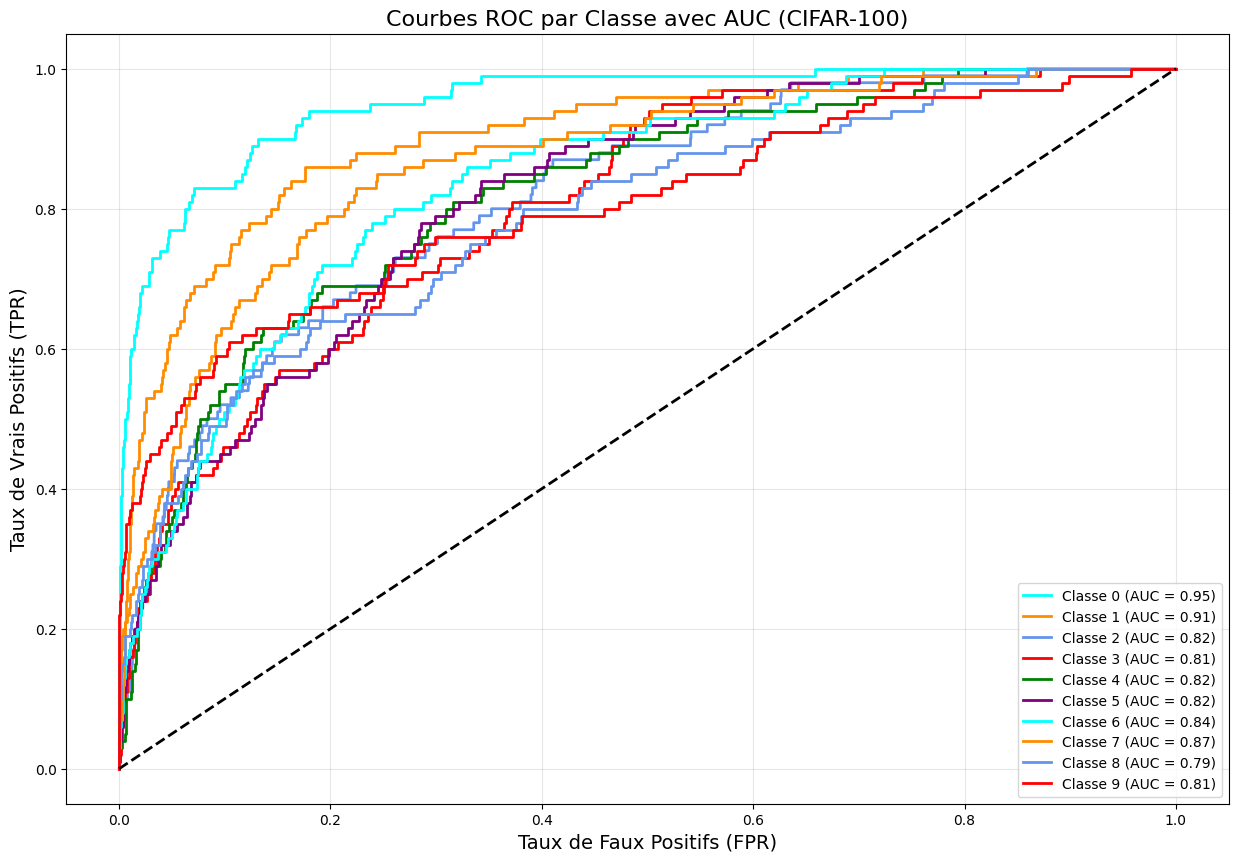

In [9]:
# Validation croisée avec MLflow
kf = KFold(n_splits=3, shuffle=True, random_state=42)
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=20,
    seed=42,
    overwrite=True,
    directory='grid_search_dir',
    project_name='cifar100_mlp'
)

fold_results = []
best_hyperparameters = None
best_score = -np.inf

for fold_idx, (train_index, val_index) in enumerate(kf.split(x_train_pca), 1):
    x_train_fold, x_val_fold = x_train_pca[train_index], x_train_pca[val_index]
    y_train_fold, y_val_fold = y_train_one_hot[train_index], y_train_one_hot[val_index]

    with mlflow.start_run(run_name=f"Fold_{fold_idx}"):
        # Recherche d'hyperparamètres
        tuner.search(
            x_train_fold,
            y_train_fold,
            validation_data=(x_val_fold, y_val_fold),
            epochs=50,
            batch_size=32
        )

        # Meilleur modèle pour ce fold
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        best_model = tuner.hypermodel.build(best_hps)
        history = best_model.fit(
            x_train_fold,
            y_train_fold,
            validation_data=(x_val_fold, y_val_fold),
            epochs=50,
            batch_size=32,
            verbose=0
        )
        fold_val_loss, fold_val_accuracy = best_model.evaluate(x_val_fold, y_val_fold, verbose=2)

        # Logs MLflow
        mlflow.log_param("fold_idx", fold_idx)
        mlflow.log_param("units_layer_1", best_hps.get('units_layer_1'))
        mlflow.log_param("units_layer_2", best_hps.get('units_layer_2'))
        mlflow.log_param("units_layer_3", best_hps.get('units_layer_3'))
        mlflow.log_param("units_layer_4", best_hps.get('units_layer_4'))
        mlflow.log_param("learning_rate", best_hps.get('learning_rate'))
        mlflow.log_metric("val_loss", fold_val_loss)
        mlflow.log_metric("val_accuracy", fold_val_accuracy)

        # Enregistrer le modèle dans MLflow
        mlflow.keras.log_model(best_model, f"model_fold_{fold_idx}")

        fold_results.append({
            "Fold": fold_idx,
            "Validation Loss": fold_val_loss,
            "Validation Accuracy": fold_val_accuracy
        })

        if fold_val_accuracy > best_score:
            best_hyperparameters = best_hps
            best_score = fold_val_accuracy

# Résultats de la validation croisée
folds_df = pd.DataFrame(fold_results)
print("\n=== Résultats des Folds ===\n", folds_df)

# Entraîner le meilleur modèle sur l'ensemble des données
with mlflow.start_run(run_name="Final_Training"):
    final_model = tuner.hypermodel.build(best_hyperparameters)
    final_history = final_model.fit(
        x_train_pca,
        y_train_one_hot,
        validation_split=0.2,
        epochs=20,
        batch_size=32
    )

    # Évaluation sur le jeu de test
    test_loss, test_accuracy = final_model.evaluate(x_test_pca, y_test_one_hot)
    y_test_pred = final_model.predict(x_test_pca)
    test_auc = roc_auc_score(y_test_one_hot, y_test_pred, multi_class="ovr")

    # Logs finaux avec MLflow
    mlflow.log_param("n_components_PCA", 500)
    mlflow.log_param("final_epochs", 20)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_auc", test_auc)

    # Enregistrer le modèle final
    mlflow.keras.log_model(final_model, "final_model")

print(f"\nTest Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test AUC: {test_auc}")

# Tracer les courbes ROC
n_classes = y_test_one_hot.shape[1]
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(15, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple'])
for i, color in zip(range(10), colors):  
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title("Courbes ROC par Classe avec AUC (CIFAR-100)", fontsize=16)
plt.xlabel("Taux de Faux Positifs (FPR)", fontsize=14)
plt.ylabel("Taux de Vrais Positifs (TPR)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.show() 

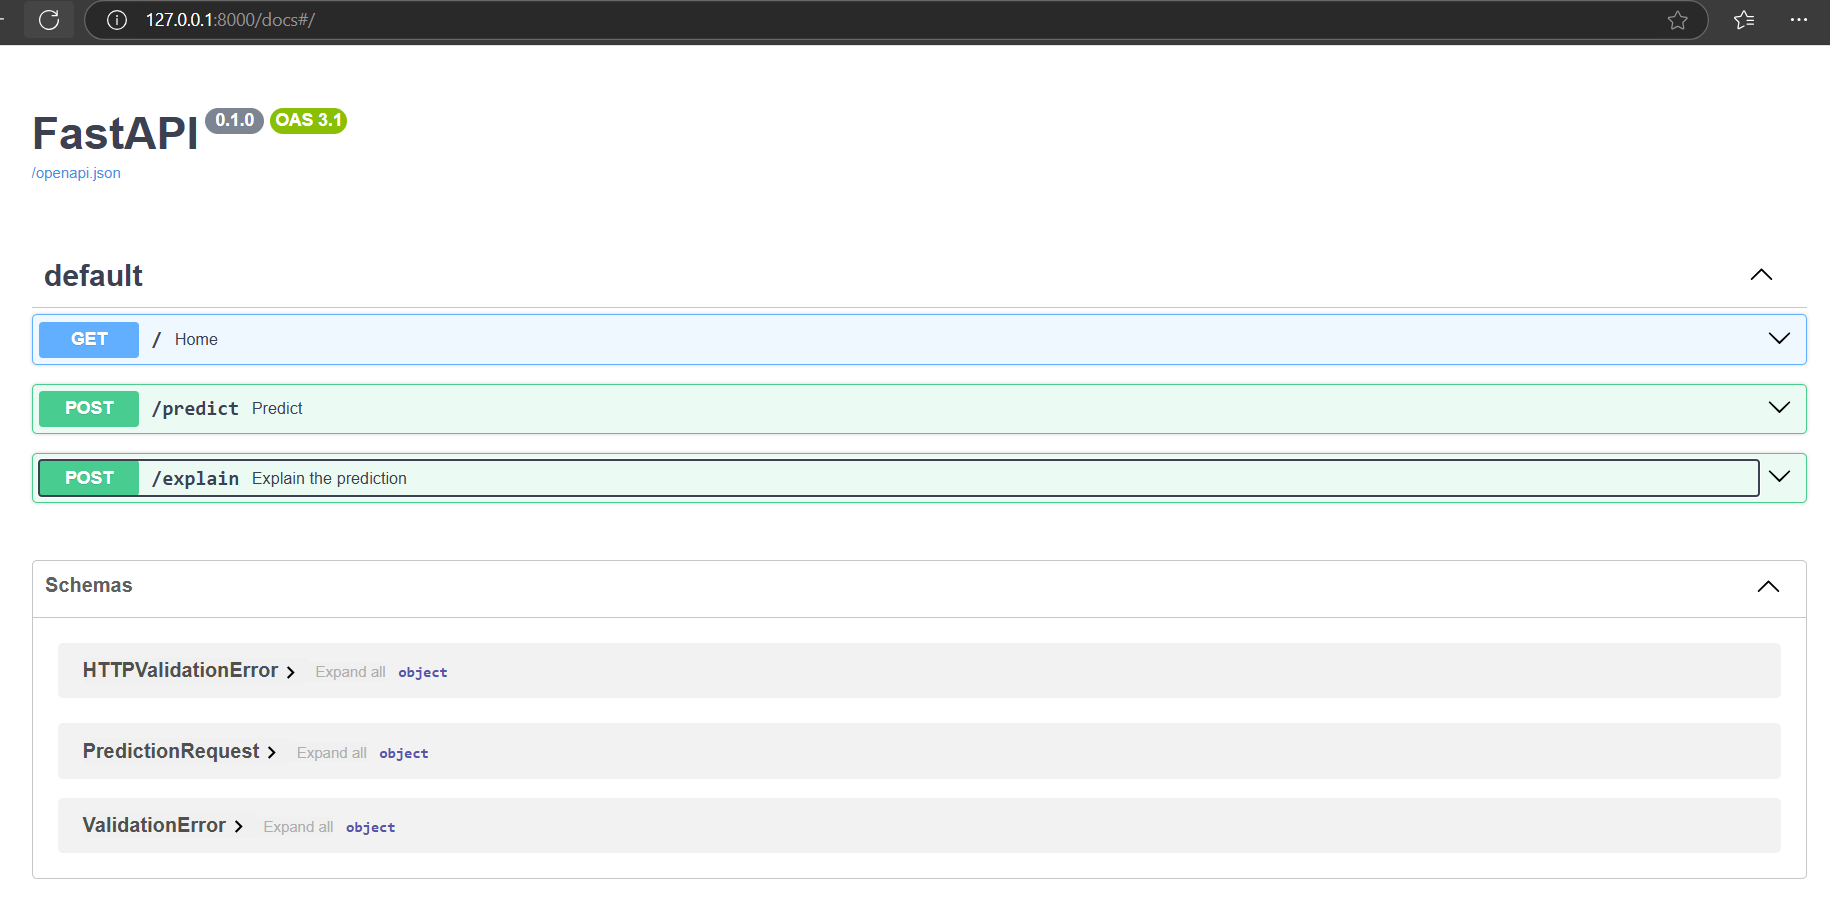

In [5]:
from IPython.display import Image, display

# Chemin vers l'image (avec r pour une chaîne brute ou en utilisant des barres obliques)
image_path = r"C:\Users\MSI\Desktop\1.png"  

# OU
# image_path = "C:/Users/MSI/Desktop/1.png"  # Utilisation de barres obliques

# Afficher l'image
display(Image(filename=image_path))



In [ ]:
from IPython.display import Image, display

# Chemin vers l'image (avec r pour une chaîne brute ou en utilisant des barres obliques)
image_path = r"C:\Users\MSI\Desktop\1.png"  

# OU
# image_path = "C:/Users/MSI/Desktop/1.png"  # Utilisation de barres obliques

# Afficher l'image
display(Image(filename=image_path))

